# Tarea 3 Cosmología
Antonia Cisternas <br>
Profesor: Doménico Sapone <br>
Auxiliares: Francisco Colipi & Vicente Pedreros

## P6

In [23]:
import camb
from camb import model, initialpower

import numpy as np
import matplotlib.pyplot as plt
from scipy.misc import derivative
from scipy import interpolate
from scipy.integrate import odeint, quadrature

Creating functions

In [24]:
#Fiducial parameters
wb = 0.022445
wm = 0.143648
h = 0.67
c = 300000

Omega_b0 = wb/ (h**2)
H0 = 100 * h
Omega_m0 = wm/ (h**2)
ns = 0.96 # Spectral index of the primordial density power spectrum
Omega_DE0 = 0.68

m_nu = 0.06
w0 = -1
wa = 0

In [39]:
def E(z):
        Omega_k0 = 1- Omega_m0 - Omega_DE0
        return np.sqrt(Omega_m0* ((1+z)**3) + Omega_DE0*((1+z)**(3*(1 + w0+ wa)))* np.exp(-3*wa*(z/(1+z))) + Omega_k0*((1+z)**2))

def H(a):
        H0 = 100 * h
        z= 1/a -1
        return H0* E(z)
def H_derivative(a, eps= 1e-6):
        return derivative(H, a, dx=eps)

def Omega_m(z):
        return Omega_m0* (1+z)**3/(E(z)**2)

def fmodel(f, a):
        dfda= -f**2/a-(2/a + (H_derivative(a))/H(a))*f + 3*Omega_m(1/a-1)/(2*a)
        return dfda

    # obtaining the value of f
def fint(z):
        f0=1
        # Scale factor values
        aint = np.linspace(0.01,1.0,101)
        fmodelint = odeint(fmodel, f0, aint)
        fmodelintf = np.asarray(fmodelint).squeeze()
        interp_type = 'cubic'
        return interpolate.interp1d(aint,fmodelintf,kind=interp_type)(1/(1+z))

def growth(z):
        return np.exp(-quadrature(lambda zx: (fint(zx) - 1)/(1+zx), 0, z)[0])


C:\Users\antoc\AppData\Local\Temp\ipykernel_10736\2273335511.py:30: DeprecationWarning: `scipy.integrate.quadrature` is deprecated as of SciPy 1.12.0and will be removed in SciPy 1.15.0. Please use`scipy.integrate.quad` instead.
  return np.exp(-quadrature(lambda zx: (fint(zx) - 1)/(1+zx), 0, z)[0])
C:\Users\antoc\AppData\Local\Temp\ipykernel_10736\2273335511.py:10: DeprecationWarning: scipy.misc.derivative is deprecated in SciPy v1.10.0; and will be completely removed in SciPy v1.12.0. You may consider using findiff: https://github.com/maroba/findiff or numdifftools: https://github.com/pbrod/numdifftools
  return derivative(H, a, dx=eps)


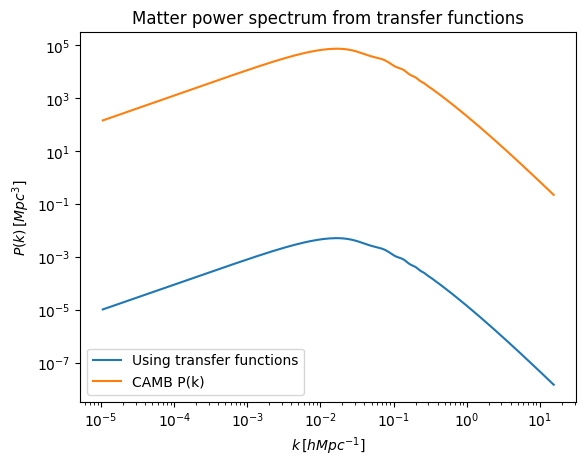

In [45]:
kmax=10 
k_per_logint = 30
zs = [200, 500,800, 1090]

pars = camb.CAMBparams()
pars.set_cosmology(H0=67.5, ombh2=0.022, omch2=0.122)
pars.InitPower.set_params(ns=0.965)
pars.set_matter_power(redshifts=[0], kmax=kmax)
results= camb.get_results(pars)

trans = results.get_matter_transfer_data()
#get kh - the values of k/h at which they are calculated
kh = trans.transfer_data[0,:,0]
#transfer functions for different variables, e.g. CDM density and the Weyl potential
#CDM perturbations have grown, Weyl is O(1) of primordial value on large scales
delta = trans.transfer_data[model.Transfer_cdm-1,:,0]
W = trans.transfer_data[model.Transfer_Weyl-1,:,0]

#Check we can get the matter power spectrum from the transfer function as expected
k = kh*results.Params.h
transfer = trans.transfer_data[model.Transfer_tot-1,:,0]
#a = 1/(1+z)
a_0 = 0.5
n_s= 0.96
delta_H = 10**(-5)
matter_power = transfer**2 * growth(1/a_0 -1)**2 * H0**(-3) * (kh/H0)**n_s * 2 *np.pi**2 * (delta_H**2)/(Omega_m0**2)

kh2,zs,PK = results.get_linear_matter_power_spectrum(hubble_units=False)

plt.loglog(kh,matter_power, label = 'Using transfer functions')
plt.title('Matter power spectrum from transfer functions')
plt.loglog(kh, PK[0,:], label = 'CAMB P(k)');
plt.legend()
plt.xlabel(r'$k\, [h Mpc^{-1}]$');
plt.ylabel(r'$P(k)\, [Mpc^3]$');


Using only CAMB

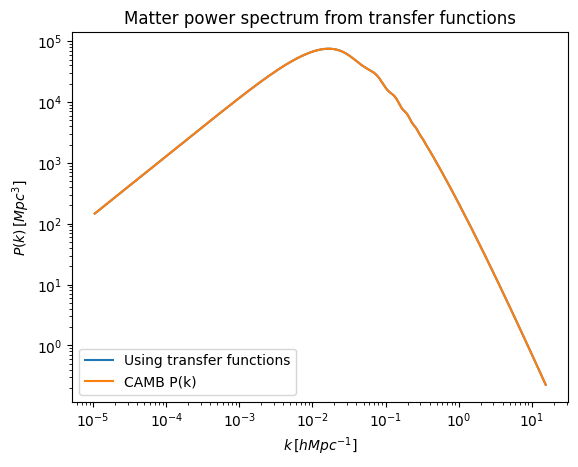

In [44]:
kmax=10 
k_per_logint = 30
zs = [200, 500,800, 1090]

pars = camb.CAMBparams()
pars.set_cosmology(H0=67.5, ombh2=0.022, omch2=0.122)
pars.InitPower.set_params(ns=0.965)
pars.set_matter_power(redshifts=[0], kmax=kmax)
results= camb.get_results(pars)

trans = results.get_matter_transfer_data()
#get kh - the values of k/h at which they are calculated
kh = trans.transfer_data[0,:,0]
#transfer functions for different variables, e.g. CDM density and the Weyl potential
#CDM perturbations have grown, Weyl is O(1) of primordial value on large scales
delta = trans.transfer_data[model.Transfer_cdm-1,:,0]
W = trans.transfer_data[model.Transfer_Weyl-1,:,0]

#Check we can get the matter power spectrum from the transfer function as expected
k = kh*results.Params.h
transfer = trans.transfer_data[model.Transfer_tot-1,:,0]
primordial_PK = results.Params.scalar_power(k)
matter_power = primordial_PK*transfer**2*k**4 / (k**3/(2*np.pi**2))

#compare with CAMB's explicit output for the matter power spectrum
kh2,zs,PK = results.get_linear_matter_power_spectrum(hubble_units=False)

plt.loglog(kh,matter_power, label = 'Using transfer functions')
plt.title('Matter power spectrum from transfer functions')
plt.loglog(kh, PK[0,:], label = 'CAMB P(k)');
plt.legend()
plt.xlabel(r'$k\, [h Mpc^{-1}]$');
plt.ylabel(r'$P(k)\, [Mpc^3]$');


## P9

## Hands-on Session

### 1. Exploring Parameter Sensitivity (Fisher Matrix Approach)

**Task**: Modify the SNIa Fisher matrix code to evaluate the sensitivity of different cosmological parameters (e.g., $\Omega_m$, $w$, $\Omega_\Lambda$). Understand how changes in the input data influence the constraints on the parameters.

**Exercise**:
- Vary the number of supernovae or their distribution over redshift and see how it impacts the Fisher matrix.
- Analyze how the uncertainty in each parameter changes based on these variations.
- Plot the contours showing the confidence regions and discuss which parameters are most sensitive to the changes.

### 2. Cosmological Model Comparison (MCMC Approach)

**Task**: Run MCMC simulations for different cosmological models using the SNIa data (e.g., $\Lambda$CDM vs. $w$CDM).

**Objective**: Demonstrate how to compare models and interpret the posterior distributions.

**Exercise**:
- Implement different priors (flat, Gaussian) for parameters like $\Omega_m$ and $w$, and observe how these priors affect the posteriors.
- Visualize the posterior distributions and compute the confidence intervals for each parameter.
- Compare the goodness-of-fit and the Bayesian evidence between the models.


### 3. Bayesian Model Selection and Evidence Calculation

**Task**: Calculate the evidence for different cosmological models using the MCMC outputs and compare models using the Bayes factor.

**Exercise**:
- Use the output of the MCMC runs to compute the evidence for each model and the corresponding Bayes factor.
- Analyze and interpret whether the data prefer a cosmological constant ($w = -1$) or a more general dark energy model ($w \neq -1$).
- Discuss how prior choices influence the evidence calculation.